# Testing AudioMPS class

In [1]:
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

sys.path.append("../")

from model import AudioMPS

In [2]:
sess = tf.InteractiveSession()

## Load Data

In [3]:
BATCH_SIZE = 32

In [4]:
organ_dataset = tf.data.TFRecordDataset('../data/organ.tfrecords')

In [5]:
parse_function = lambda example_proto: tf.parse_single_example(example_proto,
                                                               {"audio": tf.FixedLenFeature([2**16], dtype=tf.float32)})

In [6]:
organ_dataset = organ_dataset.map(parse_function)  # Parse the record into tensors.

In [7]:
organ_dataset = organ_dataset.batch(batch_size=BATCH_SIZE).shuffle(buffer_size=10000).repeat()
organ_iterator = organ_dataset.make_one_shot_iterator()
organ_batch = organ_iterator.get_next()

In [8]:
organ_batch['audio']

<tf.Tensor 'IteratorGetNext:0' shape=(?, 65536) dtype=float32>

In [9]:
sess.run(tf.zeros_like(organ_batch['audio'][:,0]))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

An example waveform

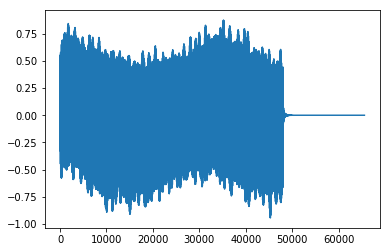

In [10]:
plt.plot(sess.run(organ_batch['audio'])[0])

Close up

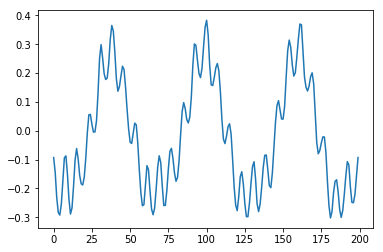

In [11]:
plt.plot(sess.run(organ_batch['audio'])[0][20000:20200])

Here's the derivative

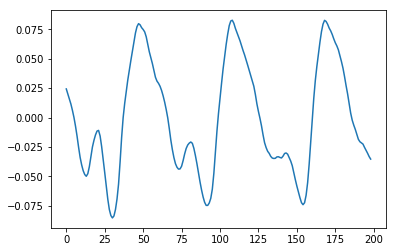

In [12]:
plt.plot(np.diff(sess.run(organ_batch['audio'])[0][20000:20200]))

## Checking the loss works

In [13]:
BOND_D = 5

In [14]:
with tf.variable_scope("organ_model"):
    organ_model = AudioMPS(organ_batch['audio'], BOND_D, delta_t=0.01)

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
sess.run(organ_model.loss)

3368.3835

## Training

### Sine wave with random phase and decay

In [17]:
sine_wave_random_phase = tf.sin(tf.range(2**9,dtype=np.float32)/10 + tf.random_uniform([1],minval=0,maxval=2*np.pi))* tf.exp(-0.01*tf.range(2**9,dtype=np.float32))

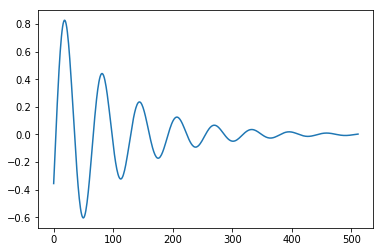

In [28]:
plt.plot(sess.run(sine_wave_random_phase))

In [25]:
sine_wave_batch = tf.stack(8*[sine_wave_random_phase], axis=0)

In [20]:
with tf.variable_scope("sine_model"):
    sine_model = AudioMPS(sine_wave_batch, BOND_D, delta_t=0.01)

In [21]:
train_op = tf.train.AdamOptimizer(1e-3).minimize(sine_model.loss)
sess.run(tf.global_variables_initializer())

0 445.59552
10 430.09607
20 421.55942
30 410.9464
40 392.60822
50 389.3622
60 388.4164
70 377.98535
80 361.94653
90 338.5067
100 324.61
110 327.1818
120 305.62186
130 293.4231
140 301.83102
150 277.7995
160 284.96265
170 274.11563
180 259.6076
190 240.43459
200 249.19243
210 239.53207
220 233.50354
230 225.53342
240 215.32321
250 201.65758
260 202.05916
270 196.73114
280 173.65811
290 166.88878
300 164.12857
310 162.52756
320 149.11797
330 144.36017
340 151.66573
350 135.68988
360 136.63103
370 123.11592
380 118.450325
390 121.083176
400 122.524925
410 110.97018
420 101.40642
430 97.876366
440 93.726135
450 101.36838
460 92.742004
470 94.28352
480 91.18438
490 82.17737
500 82.59667
510 79.45463
520 74.55784
530 74.45818
540 72.615776
550 66.626144
560 62.228615
570 61.382473
580 54.848534
590 59.320442
600 56.95356
610 47.253777
620 53.374527
630 49.217575
640 48.702427
650 40.729546
660 46.127155
670 42.32452
680 39.359627
690 39.63383
700 33.959087
710 37.526825
720 37.350143
730 32.

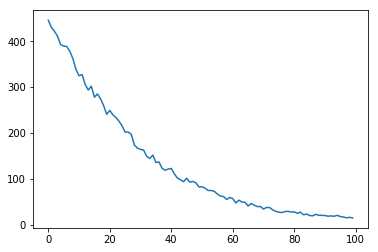

In [22]:
NUM_STEPS = 1000
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, sine_model.loss])
    if i % 10 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % 10 == 0:
        print(i, np_loss)
start = 0
plt.plot(np_losses[start:])

## Sampling 